Workshop Tutorial: Running Jobs on External Compute Resources
============================


In this tutorial we'll cover how to setup external compute resources on terra, submit, and manage jobs.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Servers](http://phoebe-project.org/docs/development/tutorials/server.ipynb)


Setup
-----------------------------

We'll load our bunde from the previous tutorial to show examples of running both a forward-model and solver remotely on terra.

In [1]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

b = phoebe.open('data/synthetic/after_optimizers.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


Server Configuration
-----------------------------

PHOEBE makes use of [crimpl](http://crimpl.readthedocs.io) as a built-in depedency to manage submitting and monitoring jobs on external compute resources.  In order to make use of one of these server, you must first configure the server within [crimpl](http://crimpl.readthedocs.io) (this only needs to be done once, after which the name of the crimpl server can be referenced from within PHOEBE on your local machine).

The available server types include:
* [LocalThread](https://crimpl.readthedocs.io/en/latest/LocalThread/)
* [RemoteSlurm](https://crimpl.readthedocs.io/en/latest/RemoteSlurm/)
* [AWSEC2](https://crimpl.readthedocs.io/en/latest/AWSEC2/)

For the workshop, you've already created a temporary account with passwordless ssh to terra, so we'll configure that server within crimpl now.

In [2]:
from phoebe.dependencies import crimpl

In [3]:
s = crimpl.RemoteSlurmServer(host='terra')

In [4]:
print(s)

<RemoteSlurmServer host=terra directory=~/crimpl>


We'll be using conda on the remote server to manage installing any necessary dependencies.  You can manually install and configure conda, or let `crimpl` do it for you (if conda is already detected as installed, this won't do any harm to call again).

In [5]:
s.install_conda()

# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"


We could have PHOEBE manage installing the dependencies for us at each job submission, but this does add some overhead.  Since we're using a non-released version of PHOEBE, that would force PHOEBE to be re-installed for each job.  So let's just install the dependencies (in a conda environment we'll call "phoebe_workhop" and reference later) we'll be needing manually and then use `install_deps=False` within PHOEBE.  You can always call [b.dependencies](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.dependencies) to see the required pip dependencies for a given bundle.

**NOTE**: this line will take a few minutes to run, but only needs to be run once to setup the conda environment on the remote server.

In [6]:
s.run_script(['pip install https://github.com/phoebe-project/phoebe2/archive/refs/heads/development.zip emcee --ignore-installed'], 
             conda_env='phoebe_workshop')

# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p ~/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; cd ~/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh"


In [7]:
s.save('terra', overwrite=True)

'/home/kyle/.crimpl/servers/terra.json'

The name provided when saving the crimpl configuration is the same name that we will reference later in PHOEBE as `crimpl_name`.  This keeps all the server configuration and potential sensitive information out of the bundle or so that the bundle (or notebook) can safely be saved and shared, while also not requiring the servers to be re-configured in each case.  If `crimpl_name` is not available from `crimpl` on the local machine, an error will be raised and the server can easily be configured or swapped.

Servers in the Bundle
-------------------------------

Servers in the bundle are added and managed as any other set of options via [b.add_server](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.add_server.md) and with "kinds" for each of the supported crimpl server types listed above:

* [localthread](http://phoebe-project.org/docs/development/api/phoebe.parameters.server.localthread.md)
* [remoteslurm](http://phoebe-project.org/docs/development/api/phoebe.parameters.server.remoteslurm.md)
* [awsec2](http://phoebe-project.org/docs/development/api/phoebe.parameters.server.awsec2.md)

Again, since we've already handled the dependencies in advance, we'll set `install_deps=False`.

In [8]:
b.add_server('remoteslurm', crimpl_name='terra',
             conda_env='phoebe_workshop',
             nprocs=48,
             install_deps=False,
             server='terra', overwrite=True)

<ParameterSet: 11 parameters | qualifiers: mail_user, nprocs, crimpl_name, install_deps, isolate_env, slurm_job_name, use_mpi, conda_env, walltime, use_conda, mail_type>

In [9]:
print(b.get_server('terra'))

ParameterSet: 10 parameters
         crimpl_name@terra@server: terra
           use_conda@terra@server: True
           conda_env@terra@server: phoebe_workshop
         isolate_env@terra@server: False
              nprocs@terra@server: 48
             use_mpi@terra@server: True
        install_deps@terra@server: False
      slurm_job_name@terra@server: 
            walltime@terra@server: 00:10:00
           mail_user@terra@server: 


use_server parameters
--------------------------

compute and solver options both have `use_server` parameters that will then dictate how [b.run_compute](http://phoebe-project.org/docs/development/api/) and [b.run_solver](http://phoebe-project.org/docs/development/api/) should handle running on external resources.  

If 'none' (as by default), the job is run in the current thread.  `use_server` in solver options are set to 'compute' by default, which means they will fallback on the `use_server` parameter in the referenced compute options.

In [10]:
print(b.filter(qualifier='use_server'))

ParameterSet: 9 parameters
      use_server@phoebe01@compute: none
        use_server@nm_fit@compute: none
       use_server@rvperiod@solver: none
   use_server@lcperiod_bls@solver: none
    use_server@lcperiod_ls@solver: none
         use_server@rvgeom@solver: none
       use_server@ebai_est@solver: none
         use_server@lcgeom@solver: none
      use_server@nm_solver@solver: compute


So in this case, if running the `nm_solver`, PHOEBE will use the solver options for the `phoebe01` compute options.

In [11]:
print(b.filter(qualifier='compute'))

ParameterSet: 1 parameters
         compute@nm_solver@solver: nm_fit


As with any other parameter in compute or solver options, these can either be set or overridden as keyword arguments when calling [b.run_compute](http://phoebe-project.org/docs/development/api/) and [b.run_solver](http://phoebe-project.org/docs/development/api/), respectively.

Running External Jobs with crimpl
--------------------------------

There are several different use-cases for running compute or solver jobs on external servers

### 1. wait and load results automatically

As always, we can send kwargs to `run_compute` or `run_solver` to override any compute/solver options.  Here we can pass the server tag (note: this is the PHOEBE server tag, not the crimpl server name) to `run_compute` overriding the `use_server` parameter, which then looks up the server options, loads the corresponding crimpl object, and passes the job to the remote machine.

Once the job is submitted, PHOEBE will poll to check its status, and retrieve the results once complete (or failed).

In [12]:
b.run_compute(compute='phoebe01', use_server='terra', model='terra_model')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.24.35/*"
# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.05.08-12.24.35/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.24.35"
# crimpl: scp crimpl_submit_script.sh /home/kyle/research/phoebe_git/phoebe2-workshop/_vePhGgRuXDWTfgovEOEBzuSIhWymaP.py terra:/home/users/kyle/crimpl/crimpl-job-2021.05.08-12.24.35/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo '_vePhGgRuXDWTfgovEOEBzuSIhWymaP.py' >> /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.24.35/crimpl-input-files.list"
# crimpl: ssh t

<ParameterSet: 8 parameters | kinds: lc, rv>

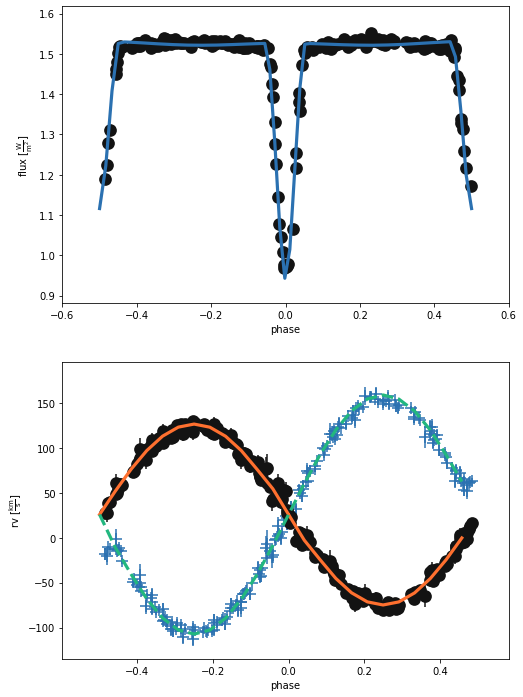

In [13]:
_ = b.plot(model='terra_model', x='phases', show=True)

### 2. detach and monitor/retrieve results 

For long jobs, we can submit the job and immediately detach from `run_compute` or `run_solver`.  This results in a a "Job Parameter" in the model or solution holding the necessary information to check the progress and retrieve the results at any time in the future. 

This is particularly useful for long solver runs as it allows you to monitor their progress *as* they're running, killing the job early if necessary.  In order to do that, we need to set `progress_every_niters` in the solver options (not available for all solvers).  This tells the solver to dump the progress to a file every set number of iterations, which can then be retrieved, loaded, and inspected.  Note that this does come with some overhead, so you don't want to necessarily set this to 1.

In [14]:
print(b.get_solver('nm_solver'))

ParameterSet: 14 parameters
        comments@nm_solver@solver: 
      use_server@nm_solver@solver: compute
         compute@nm_solver@solver: nm_fit
   expose_lnprobabilities@nm_s...: False
   continue_from@nm_solver@solver: None
   fit_parameters@nm_solver@so...: ['teffratio@binary', 'requiv@primary', 'requivratio@binary']
   initial_values@nm_solver@so...: {}
          priors@nm_solver@solver: ['dist01']
   priors_combine@nm_solver@so...: and
         maxiter@nm_solver@solver: 20
        adaptive@nm_solver@solver: False
           xatol@nm_solver@solver: 0.0001
           fatol@nm_solver@solver: 0.0001
   progress_every_niters@nm_so...: 0


In [15]:
print(b.get_parameter(qualifier='progress_every_niters', solver='nm_solver'))

Parameter: progress_every_niters@nm_solver@solver
                       Qualifier: progress_every_niters
                     Description: save the progress of the solution every n iterations.  The solution can only be recovered from an early termination by loading the bundle from a saved file and then calling b.import_solution(filename).  The filename of the saved file will default to solution.ps.progress within run_solver, or the output filename provided to export_solver suffixed with .progress.  If using detach=True within run_solver, attach job will load the progress and allow re-attaching until the job is completed.  If 0 will not save and will only return after completion.
                           Value: 0
                  Constrained by: 
                      Constrains: None
                      Related to: None



Here we'll set `progress_every_niters=10`, `maxiter=1e6`, and `fatol=xatol=1e-12`... essentially telling the optimizer to continue running until its manually terminated or exceeds the walltime.

In [16]:
b.set_value('progress_every_niters', solver='nm_solver', value=10)
b.set_value('maxiter', solver='nm_solver', value=1e6)
b.set_value('xatol', solver='nm_solver', value=1e-12)
b.set_value('fatol', solver='nm_solver', value=1e-12)

In [17]:
b.run_solver(solver='nm_solver', use_server='terra', 
             solution='nm_solution_progress', detach=True)

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.05.08-12.25.46/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46"
# crimpl: scp crimpl_submit_script.sh /home/kyle/research/phoebe_git/phoebe2-workshop/_lXQGMUMSLrsUxGtMIVnlJqrpssYpim.py terra:/home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo '_lXQGMUMSLrsUxGtMIVnlJqrpssYpim.py' >> /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/crimpl-input-files.list"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo 'phoebe_workshop' > /home/users/kyle/crimp

<Parameter: detached_job=unknown | keys: description, value, job_name, uniqueid, readonly, advanced, latexfmt>

In [18]:
print(b.get_solution('nm_solution_progress'))

ParameterSet: 2 parameters
R  detached_job@nm_solution_pr...: unknown
   comments@nm_solution_progre...: 


We can now (optionally) save the bundle, turn off our local machine, start a new python session, load the bundle, and all necessary information to check the job's status and retrieve results are handled automatically (with job information in the detached_job parameter and server setup/credentials in the crimpl configuration to avoid any security concerns when sharing bundles).

In [19]:
b.save('running_job.phoebe')

import phoebe
b = phoebe.open('running_job.phoebe')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


Depending on how long we expect the job to take, we have a number of available methods we can call to act on this detached job parameter:

* [b.get_job_status](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.get_job_status.md)
* [b.get_job_crimpl_object](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.get_job_crimpl_object.md)
* [b.attach_job](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.attach_job.md)
* [b.load_job_progress](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.load_job_progress.md)
* [b.kill_job](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.kill_job.md)
* [b.resubmit_job](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.resubmit_job.md)

Here we'll call [b.attach_job](http://phoebe-project.org/docs/development/api/phoebe.frontend.bundle.Bundle.attach_job.md), which will re-enter the loop waiting for the job to complete and then load the results.

In [20]:
b.get_job_status(solution='nm_solution_progress')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: received ssh error, waiting 5s then retrying
# crimpl: received ssh error, waiting 10s then retrying
# crimpl: received ssh error, waiting 15s then retrying
# crimpl: received ssh error, waiting 20s then retrying
# crimpl: ssh command succeeded
# crimpl: ssh terra "cat /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/crimpl_slurm_id"
# crimpl: ssh terra "squeue -j 1459"


'running'

Calling `load_job_progress` will fail until the first progress file is written, so just for the sake of letting the notebook run by executing all cells, we'll force sleeping for 2 minutes.

In [21]:
from time import sleep
sleep(120)

In [22]:
b.load_job_progress(solution='nm_solution_progress')

# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/*"
# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/*"
# crimpl: scp terra:/home/users/kyle/crimpl/crimpl-job-2021.05.08-12.25.46/_lXQGMUMSLrsUxGtMIVnlJqrpssYpim.out.progress ./


<ParameterSet: 11 parameters | qualifiers: initial_values, fitted_units, adopt_parameters, fitted_twigs, success, niter, fitted_values, message, fitted_uniqueids, adopt_distributions, adopt_values>

In [23]:
print(b.filter(qualifier=['fitted_twigs', '*_values', '*_lnprobability', 'niter', 'message'], 
               solution='nm_solution_progress'))

ParameterSet: 6 parameters
R  fitted_twigs@nm_solution_pr...: ['teffratio@binary@orbit@component' 'requiv@primary@star@component'
 'requivratio@binary@orbit@component']
   adopt_values@nm_solution_pr...: True
R  message@nm_solution_progres...: running
R  niter@nm_solution_progress@...: 20
R  initial_values@nm_solution_...: [0.92530326 1.27852473 1.08188267]
R  fitted_values@nm_solution_p...: [0.92561197 1.268032   1.09592   ]


In [24]:
b.run_compute(compute='nm_fit', solution='nm_solution_progress', model='progress_model')

100%|██████████| 64/64 [00:00<00:00, 86.45it/s]


<ParameterSet: 13 parameters | kinds: lc, rv>

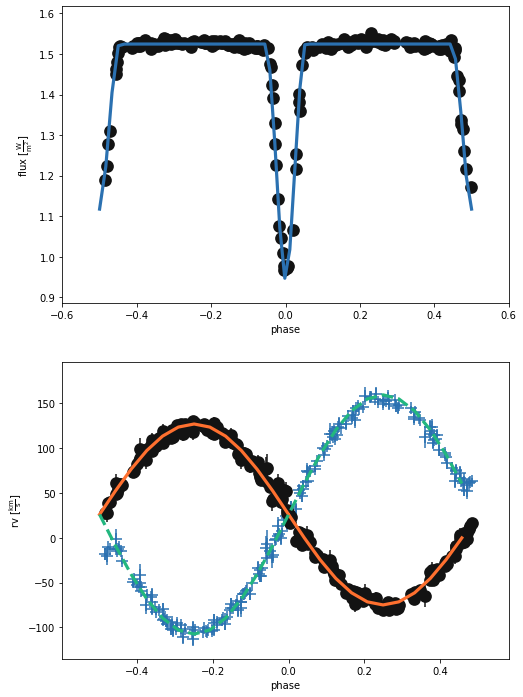

In [25]:
_ = b.plot(model='progress_model', x='phases', show=True)

We can essentially keep running this loop of code blocks to re-load the latest progress file from the server, compare results, and decide whether to keep it running or terminate the job.

If we're happy with the results before `maxiter`, `xatol`, `fatol` or the server's `walltime` have been reached, we can kill the job.  

In [26]:
b.kill_job(solution='nm_solution_progress')

# crimpl: ssh terra "scancel 1459"


<ParameterSet: EMPTY>

### 3. export script

See the [online servers tutorial](http://phoebe-project.org/docs/development/tutorials/server.ipynb) for more use-cases, including exporting a script capable of submitting the job externally or a script to copy and submit manually.